In [36]:
import torch
import torch.nn as nn
from torchinfo import summary
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import numpy as np
from torchviz import make_dot
from graphviz import Digraph, Source
from IPython.display import display, Image

import seaborn as sns
import matplotlib.pyplot as plt
import netron
import random

In [37]:
RANDOM_SEED = 42
DATA_URL = "https://raw.githubusercontent.com/gscdit/Breast-Cancer-Detection/refs/heads/master/data.csv"
BATCH_SIZE = 32
LR = 1e-3
EPOCHS = 50
PATIENCE = 10
MODEL_PATH = "breast_cancer_ann.pt"
ONNX_PATH = "breast_cancer_ann.onnx"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [38]:
def set_seed(seed=RANDOM_SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

In [39]:
print("Loading data from:", DATA_URL)
df = pd.read_csv(DATA_URL)

# Drop 'id' and any unnamed index columns if present
if 'id' in df.columns:
    df = df.drop(columns=['id'])
unnamed = [c for c in df.columns if str(c).startswith("Unnamed")]
if unnamed:
    df = df.drop(columns=unnamed)

df = df.dropna()


Loading data from: https://raw.githubusercontent.com/gscdit/Breast-Cancer-Detection/refs/heads/master/data.csv


In [40]:
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [41]:
df.shape

(569, 31)

In [42]:
# Label encoding 
if 'diagnosis' not in df.columns:
    raise RuntimeError("Expected column 'diagnosis' in CSV")
le = LabelEncoder()
df['diagnosis'] = le.fit_transform(df['diagnosis'])  # M->1, B->0

X_all = df.drop(columns=['diagnosis']).select_dtypes(include=[np.number]).values
y_all = df['diagnosis'].values

print("Features shape:", X_all.shape, "Labels shape:", y_all.shape)
print("Label classes:", le.classes_)

Features shape: (569, 30) Labels shape: (569,)
Label classes: ['B' 'M']


In [43]:
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [44]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X_all, y_all, test_size=0.30, random_state=RANDOM_SEED, stratify=y_all
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=RANDOM_SEED, stratify=y_temp
)

print("Train / Val / Test shapes:", X_train.shape, X_val.shape, X_test.shape)


Train / Val / Test shapes: (398, 30) (85, 30) (86, 30)


In [45]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [46]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [47]:

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds = TensorDataset(X_val_t, y_val_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [48]:
class BreastCancerANN(nn.Module):
    def __init__(self, n_features):
        super(BreastCancerANN, self).__init__()

        # Layer 1
        self.fc1 = nn.Linear(n_features, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.3)

        # Layer 2
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.25)

        # Layer 3
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(0.2)

        # Layer 4
        self.fc4 = nn.Linear(32, 16)
        self.bn4 = nn.BatchNorm1d(16)
        self.dropout4 = nn.Dropout(0.1)

        # Output
        self.out = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)

        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)

        x = torch.relu(self.bn4(self.fc4(x)))
        x = self.dropout4(x)

        x = torch.sigmoid(self.out(x))
        return x

# Instantiate model
model = BreastCancerANN(X_train.shape[1]).to(DEVICE)

# Print model summary
try:
    print(summary(model, input_size=(BATCH_SIZE, X_train.shape[1])))
except Exception as e:
    print("Could not print model summary:", e)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)


Layer (type:depth-idx)                   Output Shape              Param #
BreastCancerANN                          [32, 1]                   --
├─Linear: 1-1                            [32, 128]                 3,968
├─BatchNorm1d: 1-2                       [32, 128]                 256
├─Dropout: 1-3                           [32, 128]                 --
├─Linear: 1-4                            [32, 64]                  8,256
├─BatchNorm1d: 1-5                       [32, 64]                  128
├─Dropout: 1-6                           [32, 64]                  --
├─Linear: 1-7                            [32, 32]                  2,080
├─BatchNorm1d: 1-8                       [32, 32]                  64
├─Dropout: 1-9                           [32, 32]                  --
├─Linear: 1-10                           [32, 16]                  528
├─BatchNorm1d: 1-11                      [32, 16]                  32
├─Dropout: 1-12                          [32, 16]                  --
├─L

In [49]:
history = {'train_loss': [], 'val_loss': []}
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    val_running = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_running += loss.item() * xb.size(0)
    val_loss = val_running / len(val_loader.dataset)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Early stopping + checkpoint
    if val_loss < best_val_loss - 1e-6:
        best_val_loss = val_loss
        torch.save(model.state_dict(), MODEL_PATH)
        patience_counter = 0
        print("  Saved best model.")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"Early stopping at epoch {epoch}")
            break

# Load best model
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

Epoch 001 | Train Loss: 0.5901 | Val Loss: 0.5939
  Saved best model.
Epoch 002 | Train Loss: 0.4999 | Val Loss: 0.4740
  Saved best model.
Epoch 003 | Train Loss: 0.4366 | Val Loss: 0.3959
  Saved best model.
Epoch 004 | Train Loss: 0.3784 | Val Loss: 0.3376
  Saved best model.
Epoch 005 | Train Loss: 0.3445 | Val Loss: 0.3085
  Saved best model.
Epoch 006 | Train Loss: 0.3094 | Val Loss: 0.2843
  Saved best model.
Epoch 007 | Train Loss: 0.2809 | Val Loss: 0.2521
  Saved best model.
Epoch 008 | Train Loss: 0.2527 | Val Loss: 0.2401
  Saved best model.
Epoch 009 | Train Loss: 0.2316 | Val Loss: 0.2048
  Saved best model.
Epoch 010 | Train Loss: 0.2337 | Val Loss: 0.1835
  Saved best model.
Epoch 011 | Train Loss: 0.2154 | Val Loss: 0.1833
  Saved best model.
Epoch 012 | Train Loss: 0.1741 | Val Loss: 0.1706
  Saved best model.
Epoch 013 | Train Loss: 0.1759 | Val Loss: 0.1669
  Saved best model.
Epoch 014 | Train Loss: 0.1579 | Val Loss: 0.1481
  Saved best model.
Epoch 015 | Train Lo

BreastCancerANN(
  (fc1): Linear(in_features=30, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=32, out_features=16, bias=True)
  (bn4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.1, inplace=False)
  (out): Linear(in_features=16, out_features=1, bias=True)
)

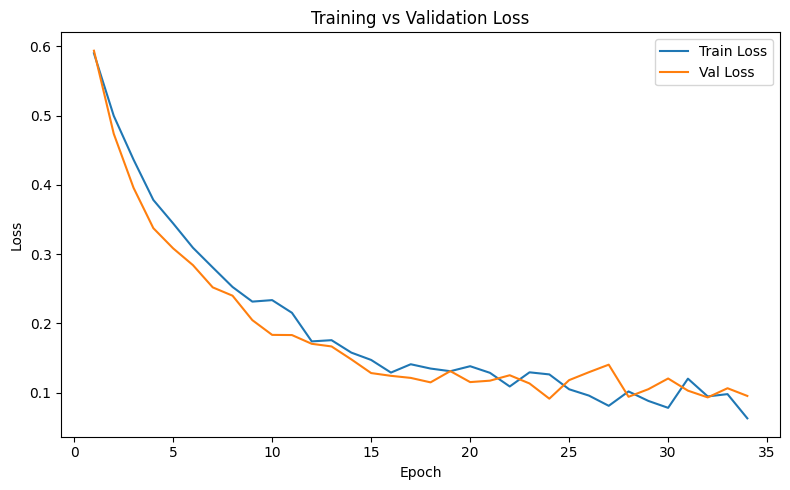

In [50]:
plt.figure(figsize=(8,5))
sns.lineplot(
    x=range(1, len(history['train_loss'])+1),
    y=history['train_loss'],
    label='Train Loss'
)
sns.lineplot(
    x=range(1, len(history['val_loss'])+1),
    y=history['val_loss'],
    label='Val Loss'
)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.tight_layout()

plt.show()  


In [51]:
all_preds = []
all_targets = []
all_probs = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        logits = model(xb)                  
        probs = logits.cpu().numpy().flatten()
        preds = (probs >= 0.5).astype(int)
        all_probs.extend(probs.tolist())
        all_preds.extend(preds.tolist())
        all_targets.extend(yb.cpu().numpy().flatten().astype(int).tolist())

acc = accuracy_score(all_targets, all_preds)
cm = confusion_matrix(all_targets, all_preds)
report = classification_report(all_targets, all_preds, digits=4)

print("\nTest Accuracy:", acc)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

# Optionally show first 20 predictions vs actual
print("\nSample (actual -> predicted -> prob):")
for i in range(min(20, len(all_preds))):
    print(f"{all_targets[i]} -> {all_preds[i]} (p={all_probs[i]:.4f})")


Test Accuracy: 1.0
Confusion Matrix:
 [[54  0]
 [ 0 32]]

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        54
           1     1.0000    1.0000    1.0000        32

    accuracy                         1.0000        86
   macro avg     1.0000    1.0000    1.0000        86
weighted avg     1.0000    1.0000    1.0000        86


Sample (actual -> predicted -> prob):
1 -> 1 (p=0.9933)
0 -> 0 (p=0.0503)
0 -> 0 (p=0.0335)
0 -> 0 (p=0.0427)
0 -> 0 (p=0.0383)
1 -> 1 (p=0.9478)
0 -> 0 (p=0.0313)
1 -> 1 (p=0.9881)
0 -> 0 (p=0.0309)
0 -> 0 (p=0.0444)
0 -> 0 (p=0.0490)
0 -> 0 (p=0.0357)
1 -> 1 (p=0.9522)
0 -> 0 (p=0.0381)
0 -> 0 (p=0.0378)
0 -> 0 (p=0.0371)
0 -> 0 (p=0.0315)
1 -> 1 (p=0.8508)
0 -> 0 (p=0.0332)
0 -> 0 (p=0.0448)


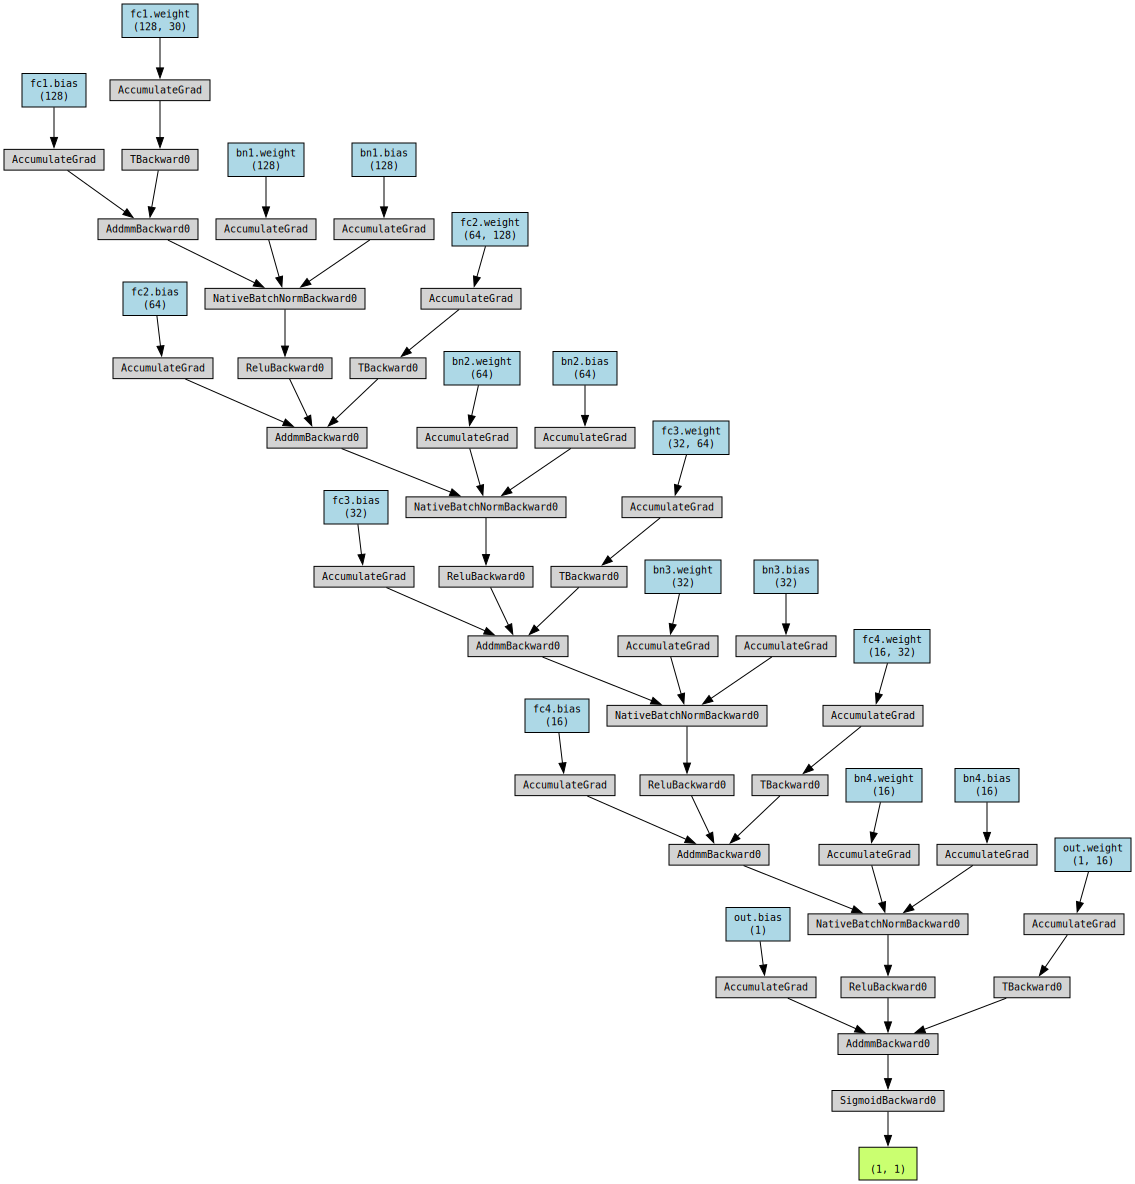

Saved computation_graph.png


In [52]:
try:
    sample = X_test_t[0].unsqueeze(0).to(DEVICE)   # single sample
    y_out = model(sample)
    dot = make_dot(y_out, params=dict(model.named_parameters()))
    # Display graph source (useful in notebook)
    display(Source(dot.source))
    # Save as png
    dot.format = 'png'
    dot.render('computation_graph', cleanup=True)
    print("Saved computation_graph.png")
except Exception as e:
    print("Could not create torchviz graph:", e)


Neuron-level branching graph saved as branching_model.png


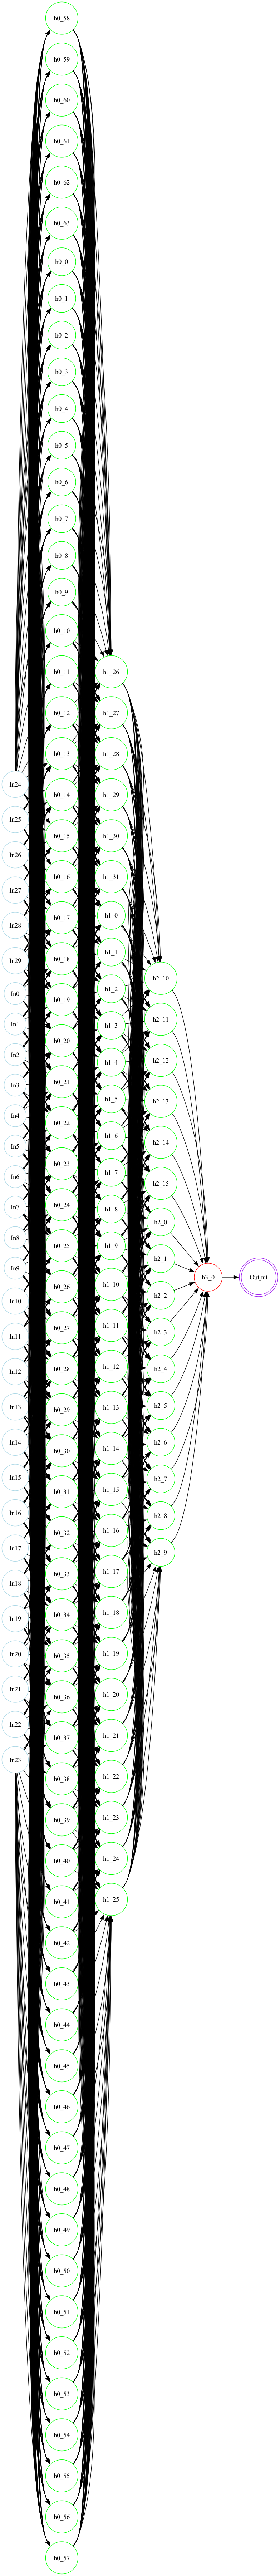

In [53]:
def draw_branching_model():
    dot = Digraph(format='png')
    dot.attr(rankdir='LR')

    # Inputs (use number of features)
    n_inputs = X_train.shape[1]
    for i in range(n_inputs):
        dot.node(f'in{i}', f'In{i}', shape='circle', color='lightblue')

    # Hidden layers (match model arch: 64,32,16,1)
    layers = [64, 32, 16, 1]
    prev = [f'in{i}' for i in range(n_inputs)]

    for li, size in enumerate(layers):
        curr = [f'h{li}_{j}' for j in range(size)]
        color = 'green' if li < (len(layers)-1) else 'red'
        for node in curr:
            dot.node(node, node, shape='circle', color=color)
        # Connect previous to current (fully connected)
        for p in prev:
            for c in curr:
                dot.edge(p, c)
        prev = curr

    out_name = 'output'
    dot.node(out_name, 'Output', shape='doublecircle', color='purple')
    for p in prev:
        dot.edge(p, out_name)

    filename = dot.render('branching_model', format='png')
    print("Neuron-level branching graph saved as", filename)
    try:
        display(Image(filename))
    except Exception:
        pass

draw_branching_model()

In [55]:
try:
    dummy = torch.randn(1, X_train.shape[1], device=DEVICE)
    torch.onnx.export(
        model,
        dummy,
        ONNX_PATH,
        input_names=["input"],
        output_names=["output"],
        opset_version=16,
        dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}}
    )
    print("Exported ONNX ->", ONNX_PATH)

except Exception as e:
    print("ONNX export failed:", e)

print("Done.")

/var/folders/sy/m7k6mw5s73vb6glpqkq98gyr0000gn/T/ipykernel_2244/174269804.py:3: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W1211 12:10:17.202000 2244 site-packages/torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 16 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `BreastCancerANN([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `BreastCancerANN([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


The model version conversion is not supported by the onnxscript version converter and fallback is enabled. The model will be converted using the onnx C API (target version: 16).


[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 4 of general pattern rewrite rules.
Exported ONNX -> breast_cancer_ann.onnx
Done.
